In [2]:
import pandas as pd
from training.predictionAlgo import naiveNextEventPredictor
from preprocessing.dataParsing import parseData
from preprocessing.dataSplitting import dataSplitter

# Convert csv into dataframe
df_training_raw = pd.read_csv('.\data\BPI2012Training.csv')
df_test_raw = pd.read_csv('.\data\BPI2012Test.csv')

# Parsing data
(df_training, df_2012_last_event_per_case_train) = parseData(df_training_raw)
(df_test, df_2012_last_event_per_case_test) = parseData(df_test_raw)

# Clean and split the data into train, validation & test data
(df_training, df_validation, df_test) = dataSplitter(df_training, df_test)

In [3]:
from sklearn.preprocessing import OneHotEncoder

unique_training_events = df_training['event concept:name'].unique().reshape(-1, 1)

# Define One-hot encoder
onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
onehot_encoder = onehot_encoder.fit(unique_training_events)

In [4]:
from math import ceil

number_events_mean = df_training.groupby('case concept:name').count()['event concept:name'].mean()
number_events_mean = ceil(number_events_mean)
number_events_mean

21

In [5]:
from sklearn.preprocessing import MinMaxScaler

def createInputRF(df):
    # df with only relevant training data, i.e. loan amount, current event, next event and time elapsed since registeration.
    df_relevant = df[['case concept:name', 'event concept:name', 'actual_next_event', 'case AMOUNT_REQ', 'unix_reg_time']].copy()

    # One-hot encode current and next event
    training_current_event = df_relevant['event concept:name'].to_numpy().reshape(-1, 1)
    df_relevant['event concept:name'] = onehot_encoder.transform(training_current_event).tolist()

    training_next_event = df_relevant['actual_next_event'].to_numpy().reshape(-1, 1)
    df_relevant['actual_next_event'] = onehot_encoder.transform(training_next_event).tolist()

    # Normalise loan amount
    loan_scaler = MinMaxScaler(feature_range=(0,1))
    case_amount = df_relevant['case AMOUNT_REQ'].to_numpy().reshape(-1, 1)
    df_relevant['case AMOUNT_REQ'] = np.around(loan_scaler.fit_transform(case_amount), decimals = 4)

    # Normalise time in seconds from case registeration to current event
    time_scaler = MinMaxScaler(feature_range=(0,1))
    reg_time = df_relevant['unix_reg_time'].to_numpy().reshape(-1, 1)
    df_relevant['unix_reg_time'] = np.around(loan_scaler.fit_transform(reg_time), decimals = 4)

    # Prepare input and output in form of [samples, features]
    x = []
    y = []

    # Get groupby object df by case id
    df_groupby_case_id = df_relevant.groupby('case concept:name')

    # Unique case ids
    unique_case_ids = df_relevant['case concept:name'].unique().tolist()

    # Find input and output vector in form of [samples, features]
    for unique_id in unique_case_ids:
        xy_unique_id = df_groupby_case_id.get_group(unique_id)[['event concept:name', 'actual_next_event', 'case AMOUNT_REQ', 'unix_reg_time']].values.tolist()

        base_case = xy_unique_id[0][0:2].copy()
        x_first_sample_per_case = base_case[0].copy()
        x_first_sample_per_case.extend([xy_unique_id[0][2], xy_unique_id[0][3]])
        x.append(x_first_sample_per_case)
        y.append(base_case[1].copy())

        # event[0] = current event, event[1] = next event, event[2] = loan amount, event[3] = time elapsed since registeration of case
        for event in xy_unique_id[1:]:
            base_case[0] = [prev_xs + current_x for prev_xs, current_x in zip(base_case[0], event[0])]
            x_sample = base_case[0].copy()
            x_sample.extend([event[2], event[3]])
            x.append(x_sample)
            y.append(event[1])
    return x, y

In [11]:
import numpy as np

# Determine actual next event
(df_training, df_validation) = naiveNextEventPredictor(df_training, df_validation)
(df_test, df_validation) = naiveNextEventPredictor(df_test, df_validation)

x_train, y_train = createInputRF(df_training)
x_test, y_test = createInputRF(df_test)

In [ ]:
print(y_train[0:10])

In [ ]:
import numpy as np
# Convert y_train to format [samples, features]
y_train = np.reshape(y_train, (-1, len(y_train[0])))

## finding random forest parameters


In [14]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 64, stop = 428, num = 6)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [float(round(x)) * 0.01 for x in np.linspace(5, 30, num = 6)]
min_samples_split.insert(0, 0.02)
# Minimum number of samples required at each leaf node
min_samples_leaf = [float(round(x)) * 0.01 for x in np.linspace(5, 30, num = 6)]
min_samples_leaf.insert(0, 0.02)
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [64, 136, 209, 282, 355, 428], 'max_features': ['sqrt'], 'max_depth': [5, 28, 52, 76, 100], 'min_samples_split': [0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3], 'min_samples_leaf': [0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3], 'bootstrap': [True]}


In [8]:
from sklearn.ensemble import RandomForestClassifier
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=42)
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 25, cv = 3, verbose=1, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(x_train, y_train)

In [ ]:
best_para_dict = rf_random.best_params_
best_para_dict

In [165]:
import json

with open('./BestParaRF/para{}.json'.format(15), 'w') as fp:
    json.dump(best_para_dict, fp)

In [156]:
with open('./BestParaRF/para10.json', 'r') as fp:
    data = json.load(fp)
print(data)

{'n_estimators': 184, 'min_samples_split': 0.25, 'min_samples_leaf': 0.02, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}


In [157]:
with open('./BestParaRF/para11.json', 'r') as fp:
    data = json.load(fp)
print(data)

{'n_estimators': 264, 'min_samples_split': 0.05, 'min_samples_leaf': 0.02, 'max_features': 'sqrt', 'max_depth': 76, 'bootstrap': True}


In [158]:
with open('./BestParaRF/para12.json', 'r') as fp:
    data = json.load(fp)
print(data)

{'n_estimators': 104, 'min_samples_split': 0.02, 'min_samples_leaf': 0.05, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': True}


In [162]:
with open('./BestParaRF/para13.json', 'r') as fp:
    data = json.load(fp)
print(data)

{'n_estimators': 224, 'min_samples_split': 0.02, 'min_samples_leaf': 0.02, 'max_features': 'sqrt', 'max_depth': 76, 'bootstrap': True}


In [167]:
with open('./BestParaRF/para14.json', 'r') as fp:
    data = json.load(fp)
print(data)

{'n_estimators': 264, 'min_samples_split': 0.15, 'min_samples_leaf': 0.02, 'max_features': 'sqrt', 'max_depth': 52, 'bootstrap': True}


In [4]:
# Number of trees in random forest
n_estimators = [800, 400, 600]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [400, 600]
# Minimum number of samples required to split a node
min_samples_split = [0.02, 0.05]
# Minimum number of samples required at each leaf node
min_samples_leaf = [0.02, 0.05]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
grid = {'n_estimators': n_estimators,
       'max_features': max_features,
       'max_depth': max_depth,
       'min_samples_split': min_samples_split,
       'min_samples_leaf': min_samples_leaf,
       'bootstrap': bootstrap}

print(grid)

{'n_estimators': [428, 264], 'max_features': ['sqrt'], 'max_depth': [200, 400], 'min_samples_split': [0.02, 0.05], 'min_samples_leaf': [0.02, 0.05], 'bootstrap': [True]}


In [ ]:
rf_grid = GridSearchCV(estimator = rf, param_grid = grid, cv = 3)

In [12]:
rf = RandomForestClassifier(n_estimators = 400, min_samples_split = 0.02, min_samples_leaf = 0.02, max_depth = 200, max_features = 'sqrt', bootstrap = True)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=200, max_features='sqrt',
                       min_samples_leaf=0.02, min_samples_split=0.02,
                       n_estimators=400)

In [51]:
rf.score(x_test, y_test)

0.5230746711833218

In [13]:
y_predict = rf.predict(x_test)

In [14]:
y_predict_events = onehot_encoder.inverse_transform(y_predict)
y_predict_events = y_predict_events.ravel()
print(y_predict_events[100:200])

[None None 'W_Nabellen offertes' 'W_Nabellen offertes'
 'W_Nabellen offertes' 'W_Nabellen offertes' 'W_Nabellen offertes'
 'W_Nabellen offertes' 'W_Nabellen offertes' 'W_Nabellen offertes' None
 None None None None None None None None None None 'A_PARTLYSUBMITTED'
 None 'W_Completeren aanvraag' 'W_Completeren aanvraag'
 'W_Completeren aanvraag' 'W_Completeren aanvraag'
 'W_Completeren aanvraag' 'W_Completeren aanvraag'
 'W_Completeren aanvraag' 'W_Completeren aanvraag'
 'W_Completeren aanvraag' None None None None 'W_Nabellen offertes'
 'W_Nabellen offertes' 'W_Nabellen offertes' 'W_Nabellen offertes'
 'W_Nabellen offertes' 'W_Nabellen offertes' 'W_Nabellen offertes'
 'W_Nabellen offertes' 'W_Nabellen offertes' 'W_Nabellen offertes'
 'W_Nabellen offertes' 'W_Nabellen offertes' None None None None None None
 None None None None None 'A_PARTLYSUBMITTED' None
 'W_Completeren aanvraag' 'W_Completeren aanvraag'
 'W_Completeren aanvraag' 'W_Completeren aanvraag'
 'W_Completeren aanvraag' 'A_

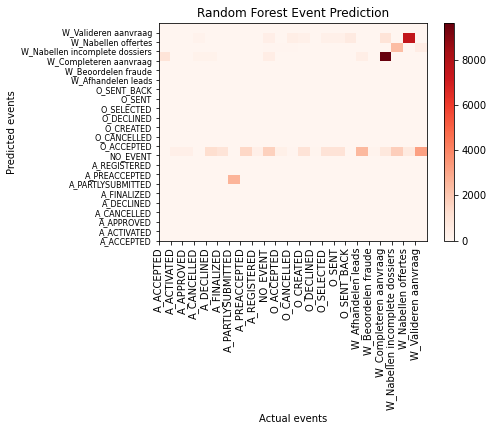

<Figure size 3600x3600 with 0 Axes>

In [17]:
from testing.testing_events import confusion_matrix_event
import math
import seaborn as sns
import matplotlib.pyplot as plt

actual_array = df_test['actual_next_event'].to_numpy().copy()

for idx, event in enumerate(actual_array):
    try: 
        np.isnan(event) 
        actual_array[idx] = 'NO_EVENT'
    except: 
        continue

y_predict_events = np.where(y_predict_events == None, 'NO_EVENT', y_predict_events)
uniqueEvents = np.unique(actual_array)

confusion_matrix_event = confusion_matrix_event(actual_array, y_predict_events, uniqueEvents)

# Plot confusion matrix
# confusion_matrix = pd.crosstab(confusion_matrix_event[uniqueEvents], confusion_matrix_event[uniqueEvents])

#confusion matrix with color
plt.pcolor(confusion_matrix_event, cmap='Reds')
plt.yticks(np.arange(len(confusion_matrix_event)), confusion_matrix_event.index)
plt.xticks(np.arange(len(confusion_matrix_event)), confusion_matrix_event.columns, rotation = 90)
plt.colorbar()
plt.tick_params(axis='y', which='major', labelsize=8)
plt.title('Random Forest Event Prediction')
plt.xlabel('Actual events')
plt.ylabel('Predicted events')
plt.figure(figsize=(50, 50))
plt.show()

In [158]:
test = np.array(['1', '2', '3', np.nan])
for idx, event in enumerate(test):
    try: 
        np.isnan(event) 
        print('Im here')
        actual_array[idx] = 'NO_EVENT'
    except: 
        continue
print(test)

['1' '2' '3' 'nan']
